In [20]:
from itertools import compress, product
import shutil, os, datetime
from typing import Tuple, List, Generator, Optional
from abc import ABC
import pandas as pd
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import seaborn as sns
from test import probability_spin

0.2455034475094771

In [2]:
class GlauberDynamics(ABC):
    
    def plot():
        raise NotImplementedError("Implement plot method")
    
    def simulate():
        raise NotImplementedError("Implement simulate method")
    

In [3]:
class GlauberHelperFunctions:
    def __init__(self, frame_length: int, frame_width: Optional[int] = None):
        self.frame_length = frame_length
        self.frame_width = frame_width
    
    def _create_initial_field_matrix(self) -> np.matrix:
        """
        Creates initial field with random spin values {-1, 1}
        
        Returns:
        --------
        np.matrix
        """
        
        if self.frame_width is None:
            self.frame_width = self.frame_length
        
        init_matrix = np.ones([self.frame_length, self.frame_width])
        for x in range(self.frame_width):
            for y in range(self.frame_length):
                init_matrix[x, y] = np.random.choice([-1, 1])
        return init_matrix
        
    def _create_axes(self) -> np.array:
        """
        Creates axes with node indexes
        """
        return np.linspace(0, self.frame_width-1, self.frame_width, int), np.linspace(0, self.frame_length-1, self.frame_length, int)
    
    def _select_random_coordinates(self, x_coords: np.array, y_coords: np.array) -> Tuple[int, int]:
        """
        Randomly assignes x, y, coordinate from array of possible values
        Parameters:
        -----------
        x_coords: np.array - array of possible values on x-axis
        y_coords: np.array - array of possible values on y-axis
        """
        x = int(np.random.choice(x_coords))
        y = int(np.random.choice(y_coords))
        return x, y
    
    def _restrict_edge_values(self, NUM_PARTICLES: int, *coords: Tuple[int, int]) -> bool:
        """
        Calculates probability that particle given coordinates will spin
        Paramters: 
        ----------
        NUM_PARTICLES: int - maximum grid limit
        coords: Tuple[int, int] - [x, y] coordinates of particle
        """
        for coord in coords:
            if (
                (coord[0] in [-1, NUM_PARTICLES]) 
                or (coord[1] in [-1, NUM_PARTICLES])
            ):
                yield False
            else:
                yield True

    def _get_spin_value(self, spin_values_matrix: np.matrix, coords: List[Tuple[int, int]]) -> Generator[int, int, int]:
        """
        Gets spin value from coordinates and matrix with spin values
        Paramters: 
        ----------
        spin_values_matrix: np.matrix - matrix of spin_values for each particle (node)
        coords: Tuple[int, int] - [x, y] coordinates of particle
        """
        for coord in coords:
            x, y = coord[0], coord[1]
            yield spin_values_matrix[int(x), int(y)]

    def _sum_neighbors(self, x: int, y: int, spin_values_matrix: np.matrix, NUM_PARTICLES: int) -> int:
        """
        Sums spin values in neighbouroughood of particle located by x, y
        Paramters: 
        ----------
        x: int - x_coordinate of particle
        y: int - y_coordinate of particle
        spin_field: np.matrix - matrix of spin_values for each particle (node)
        NUM_PARTICLES: int - maximum grid limit
        """
        node_up, node_to_left, node_to_right, node_down = (x, y+1), (x-1, y), (x+1, y), (x, y-1)
        lst_nodes = [node_up, node_to_left, node_to_right, node_down]
        is_summable = self._restrict_edge_values(NUM_PARTICLES, *lst_nodes)
        nodes_to_be_summed = list(compress(lst_nodes, is_summable))
        spin_value_of_nodes = self._get_spin_value(spin_values_matrix, nodes_to_be_summed)
        return np.sum(list(spin_value_of_nodes))
    
    def _initialize(self) -> Tuple[np.matrix, np.array]:
        """
        Creates initial variables
        """
        if self.frame_width is None:
            self.frame_width = self.frame_length
        x_axis, y_axis = self._create_axes()
        matrix = self._create_initial_field_matrix()
        return x_axis, y_axis, matrix
    
    def _should_turn(self, prob_spin: float, matrix, x, y) -> bool:
        """
        Determines if particle should spin
        Paramters:
        ----------
        prob_spin: float - calculated probability that given spin will flip its value
        """
        return np.where(prob_spin < np.random.rand(), True, False)

In [4]:
class Logging:
    
    def _logs_exist(self, path):
        return os.path.isfile(path)
    
    def _write_to_file(
        self, 
        timestamp: datetime.datetime.timestamp, 
        iter: int, 
        prob: float, 
        should_turn: bool, 
        x: int, 
        y: int
    ) -> None:
        """
        Writes log to file
        
        Parameters:
        -----------
        timestamp: datetime.datetime.timestamp - timestamp of data entry
        iter: int - iteration number
        prob: float - probability of node spinning
        should_turn: bool - decision if the nodes spin value will flip
        x: int - x coordinate
        y: int - y coordinate 
        """
        if len(str(iter)) < 4:
            self.f.write(
                f"timestamp: {timestamp} simulation: {iter} \t\t prob_spin: {prob} \t {should_turn} \t x: {x} \t y: {y}"
            )
        else:
            self.f.write(
                f"timestamp: {timestamp} simulation: {iter} \t\t prob_spin: {prob} \t {should_turn} \t x: {x} \t y: {y}"
            )
            
    def _print_log(
        self, 
        timestamp: datetime.datetime.timestamp, 
        iter: int, 
        prob: float, 
        should_turn: bool, 
        x: int, 
        y: int
    ) -> None:
        """
        Prints out log to terminal
        
        Parameters:
        -----------
        timestamp: datetime.datetime.timestamp - timestamp of data entry
        iter: int - iteration number
        prob: float - probability of node spinning
        should_turn: bool - decision if the nodes spin value will flip
        x: int - x coordinate
        y: int - y coordinate 
        """
        if len(str(iter)) < 4:
            print(
                f"timestamp: {timestamp} simulation: {iter} \t\t prob_spin: {prob} \t {should_turn} \t x: {x} \t y: {y}"
            )
        else:
            print(
                f"timestamp: {timestamp} simulation: {iter} \t\t prob_spin: {prob} \t {should_turn} \t x: {x} \t y: {y}"
            )
    
    def _get_log(self, iter: int, prob_spin: float, x: int, y: int, to_file: bool) -> None:
        """
        Prints out or writes out log
        Paramters:
        ----------
        iter: int - current iteration number
        prob_spin: float - probability that node given coordinates will spin
        x: - position on x axis
        y: - position on y axis
        to_file: bool - should this be printed out to file?
        """
        timestamp = datetime.datetime.now().timestamp()
        prob = np.round(prob_spin, 3)
        should_turn = self._should_turn(prob_spin)
        path = ""
        if not self._logs_exist(path):
            f = open("./logs/logs.txt", "w")
            f.write("logs: \n")
            f.close()
        
        if to_file:
            self.f = open(f"./logs/logs.txt", "a")
            self._write_to_file(timestamp, iter, prob_spin, should_turn, x, y)
            self.f.close()
        else:
            self._print_log(timestamp, iter, prob_spin, should_turn, x, y)

In [5]:
class Plotter:
    """
    Plots snapshot of matrix
    """
    def __init__(self, plot_name: str, figsize: Tuple[int, int], folder: str):
        self.plot_name = plot_name
        self.figsize = figsize
        self.folder = folder
        
    def _plot_grid(self, spin_field_matrix: np.matrix, iter: int, param: str) -> None:
        plt.figure(figsize=(6, 6), )
        plt.rcParams.update({'font.size': 14})
        plot = sns.heatmap(spin_field_matrix, cbar=False, annot=True)
        #if iter == 0:
        #    plt.title(f"Počáteční rozložení spinů", fontsize=20)
        #elif iter > 900:
        #    plt.title(f"Rozložení spinů po 1000. iteraci", fontsize=20)
        #else:
        #    plt.title(f"Rozložení spinů po {iter -1}. iteraci", fontsize=20)
        #plt.xlabel('x', fontsize=20)
        #plt.ylabel('y', fontsize=20)
        fig = plot.get_figure()
        fig.savefig(
            f"./data/{self.folder}/field_{self.plot_name}_{param}_num_iter_{iter}_{datetime.datetime.now().date()}.png"
        )

        fig.clf()

    def gibbs_distribution(self, energy: np.array) -> np.array:
        """
        Samples from gibbs distribution
        """
        return np.exp(- energy / self.beta)
    
    def _get_histogram_data(self, sampled_matrices: np.matrix) -> Tuple[List[str]]:
        """
        Gets data for histogram
        """
        df = pd.DataFrame({"a": sampled_matrices})
        self.df = df
        counts = df.groupby("a")['a'].count() # each unique sampled matrice count
        return [i for i in counts]
    
    def _plot_distribution_function(self, sampled_matrices: List[np.matrix], iter: int):
        """
        Plots histogram of field configuration and Gibbs distribution
        Parameters:
        -----------
        sampled_matrices: List[np.matrix] - all configurations that have been sampled
        iter: int - number of iteration
        """
        plt.close()
        vals = self._get_histogram_data(sampled_matrices)
        energies = np.linspace(1, 15, 15)
        probabilities = self.gibbs_distribution(energies)
        plt.figure(figsize=(10, 8))
        #plt.hist(vals, bins = np.linspace(0, 29, 29), density=True, label="Histogram rozdělení mřížky Isingova modelu") #label="Histogram rozdělení mřížky Isingova modelu"
        #plt.plot(energies, probabilities, label="Gibbsovo rozdělení") # legend="Gibbsovo rozdělení"
        plt.step(energies, probabilities, where='post', linestyle='-', drawstyle='steps')
        plt.hist(vals, density=True, bins = energies, label="Histogram rozdělení mřížky Isingova modelu") #label="Histogram rozdělení mřížky Isingova modelu"
        plt.xlabel('Konfigurace mřížky')
        plt.ylabel('Poměr mřížek ')
        if iter <= 1:
            plt.title(f'Rozdělení stavů mřížky po 1. iteraci')
        elif iter > 900:
            plt.title(f'Rozdělení stavů mřížky po 1000. iteraci')
        else:
            plt.title(f'Rozdělení stavů mřížky po {iter - 1} iteraci')
        plt.savefig(f"./data/hist_{self.beta}/hist_{iter}.png")
        plt.clf()
        
        
    def _plot_distribution(
        self,
        iter: int,
        sampled_matrices: np.matrix
    ) -> None:
        """
        Logs values and prints results
        """
        return self._plot_distribution_function(sampled_matrices, iter)

In [6]:
class GlauberDynamicsWithoutTemperatureField(GlauberDynamics, GlauberHelperFunctions, Logging, Plotter):
    """
    Class that simulates Ising model using Glauber dynamics not considering Temperature field
    """
    def __init__(
        self, 
        num_iterations: int, 
        beta: float,
        frame_length: int, 
        plot_name: str, 
        folder: str, 
        frame_width: Optional[int] = None, 
        figsize: Optional[Tuple[int, int]] = tuple((12, 8))  
    ):
        """
        num_iterations: int - number of Glauber Dynamics simulations
        beta: float - coefficient describing influence of energy function. (beta >= 0)
        frame_length: int - frame length
        plot_name: str - plot name (with/ without temperature)
        folder: str - where should the plot be stored
        frame_width: Optional[int] - frame width, Optional argument, if not declared will create square matrix size: frame_length x frame_length
        figsize: Optional[Tuple[int, int]] = tuple((12, 8)) - figure size
        """
        self.num_iterations = num_iterations
        self.beta = beta
        if self.beta < 0:
            raise ValueError(f"parameter beta has to be at least 0. Yours was: {self.beta}")
        GlauberHelperFunctions.__init__(self, frame_length, frame_width)
        Plotter.__init__(self, plot_name, figsize, folder)
            
    def _probability_spin(self, sum_neighbors: int) -> float:
        """
        Calculates probability that particle given coordinates will spin
        Paramters: 
        ----------
        beta: float - coefficient describing influence of energy function
        """
        prob_spin = (1 + np.tanh(self.beta * sum_neighbors)) / 2
        return  np.round(prob_spin, 3)
            
    def simulate(self, plotting_cond: int, spins: Optional[np.array] = None) -> None:
        """
        Simulates Ising model using Glauber Dynamics
        Parameters:
        -----------
        log_to_file: bool - should log be saved to file?
        """

        sampled_matrices, counter_spinning, self.timestamp = [], 0, datetime.datetime.now().timestamp()
        if spins is not None:
            matrix = spins.reshape([self.frame_length, self.frame_length])
            print(matrix.shape)
            self.frame_width = matrix.shape[1]
            self.frame_length = self.frame_width
            
        x_coords, y_coords, matrix = self._initialize()
        for iter in range(self.num_iterations):
            flatted_matrix = matrix.flatten()
            sampled_matrices.append(tuple(flatted_matrix))
            if iter == 0: # plot initial state
                self._plot_grid(matrix, iter, self.beta)
            if iter % plotting_cond == 1: # plot only few iterations
                self._plot_distribution(iter, sampled_matrices)
                self._plot_grid(matrix, iter, self.beta)
            x, y = self._select_random_coordinates(x_coords, y_coords)
            sum_neighbors_value = self._sum_neighbors(x, y, matrix, self.frame_length)
            prob_spin = self._probability_spin(sum_neighbors_value)
            if self._should_turn(prob_spin, matrix, x, y):
                counter_spinning += 1
                temp_matrix = np.copy(matrix)
                temp_matrix[x, y] = -temp_matrix[x, y]
                matrix = np.copy(temp_matrix)
        return sampled_matrices

In [7]:
class GlauberDynamicsWithTemperatureField(GlauberDynamics, GlauberHelperFunctions, Logging, Plotter):
    """
    Class that simulates Ising model using Glauber dynamics not considering Temperature field
    """
    def __init__(
        self, 
        num_iterations: int,  
        frame_length: int, 
        beta: float, 
        plot_name: str, 
        folder: str, 
        frame_width: Optional[int] = None,
        figsize: Optional[Tuple[int, int]] = tuple((12, 8))
    ):
        """
        num_iterations: int - number of Glauber Dynamics simulations
        temperature: float - temperature of temperature field
        frame_length: int - frame length
        plot_name: str - plot name (with/ without temperature)
        folder: str - where should the plot be stored
        frame_width: Optional[int] - frame width, Optional argument, if not declared will create square matrix size: frame_length x frame_length
        figsize: Optional[Tuple[int, int]] = tuple((12, 8)) - figure size
        """
        self.num_iterations = num_iterations
        self.beta = beta
        GlauberHelperFunctions.__init__(self, frame_length, frame_width)
        Plotter.__init__(self, plot_name, figsize, folder)
        
    def _probability_spin(self, sum_neighbors: int, matrix: np.matrix, x: int, y: int) -> float:
        """
        Calculates probability that particle given coordinates will spin
        Paramters: 
        ----------
        beta: float - coefficient describing influence of energy function
        """
        delta_E = 2 * sum_neighbors * matrix[x,y]
        temperature = self.beta
        prob_spin = np.exp(-delta_E / temperature) / (1 + np.exp(-delta_E / temperature))
        return np.round(prob_spin, 3)
    
    def simulate(self,  plotting_cond: int, spins: Optional[np.matrix] = None) -> None:
        """
        Simulates Ising model using Glauber Dynamics
        Parameters:
        -----------
        log_to_file: bool - should log be saved to file?
        """

        sampled_matrices, counter_spinning, self.timestamp = [], 0, datetime.datetime.now().timestamp()
        if spins is not None:
            matrix = spins.reshape([self.frame_length, self.frame_length])
            self.frame_width = matrix.shape[1]
            self.frame_length = self.frame_width
            
        x_coords, y_coords, matrix = self._initialize()
        for iter in range(self.num_iterations):
            flatted_matrix = matrix.flatten()
            sampled_matrices.append(tuple(flatted_matrix))
            if iter == 0:
                self._plot_grid(matrix, iter, self.beta)
            if iter % plotting_cond == 1:
                self._plot_distribution(iter, sampled_matrices)
                self._plot_grid(matrix, iter, self.beta)
            x, y = self._select_random_coordinates(x_coords, y_coords)
            sum_neighbors_value = self._sum_neighbors(x, y, matrix, self.frame_length)
            prob_spin = self._probability_spin(sum_neighbors_value, matrix, x, y)
            if self._should_turn(prob_spin):
                counter_spinning += 1
                temp_matrix = np.copy(matrix)
                temp_matrix[x, y] = -temp_matrix[x, y]
                matrix = np.copy(temp_matrix)
        return sampled_matrices

In [8]:
BASE = "data"
NUM_ITERATIONS = 10000
FRAME_SIZE = 5
PLOTTING_CONDITION = int(np.floor(NUM_ITERATIONS / 5))

In [9]:
beta = 1
plt.close()
[os.remove(f"{file}") for file in os.listdir(".") if "txt" in file]
if os.path.isdir(f"./data/without_temp_{beta}"):
    shutil.rmtree(f"./data/without_temp_{beta}")
os.mkdir(f"./data/without_temp_{beta}")
#os.mkdir(f"./data/hist_{beta}")
[os.remove(f"./data/{file}") for file in os.listdir("./data") if "png" in file]
[os.remove(f"./data/hist/{file}") for file in os.listdir("./data/hist") if "png" in file]

ising_model = GlauberDynamicsWithoutTemperatureField(
    num_iterations=NUM_ITERATIONS,
    beta=beta,
    frame_length=FRAME_SIZE,
    plot_name = "without_temp",
    folder = "",#f"without_temp_{beta}"
    
)
spins = np.random.choice([-1, 1], FRAME_SIZE**2)
matrices_lst = ising_model.simulate(plotting_cond=PLOTTING_CONDITION, spins=spins)



(5, 5)


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [10]:
ising_model.df['sum'] = ising_model.df['a'].apply(lambda x: sum(x))
counts = ising_model.df.groupby('sum')['sum'].count()
#counts = [i for i in counts]

In [11]:
counts

sum
-17.0       3
-15.0      15
-13.0      57
-11.0     140
-9.0      265
-7.0      432
-5.0      685
-3.0      955
-1.0     1149
 1.0     1174
 3.0     1054
 5.0      890
 7.0      623
 9.0      369
 11.0     130
 13.0      39
 15.0      22
Name: sum, dtype: int64

In [12]:
pd.read_csv("test.csv")

,Unnamed: 0,a,sum
0,0,"(1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1....",-5.0
1,1,"(1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1....",-3.0
2,2,"(1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1....",-3.0
3,3,"(1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1....",-5.0
4,4,"(1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1....",-5.0
...,...,...,...
7997,7997,"(1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1...",-1.0
7998,7998,"(1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1...",-1.0
7999,7999,"(1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1...",-1.0
8000,8000,"(1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1...",1.0


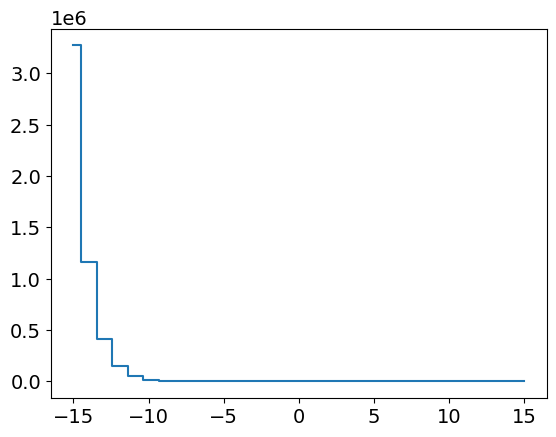

In [13]:
def gibbs(energy):
    return np.exp(- energy)


energies = np.linspace(-15, 15, 30)

v = gibbs(energies)
plt.step(energies, v, where='mid', linestyle='-', drawstyle='steps')

In [14]:
print(sorted(counts, reverse=True))

[1174, 1149, 1054, 955, 890, 685, 623, 432, 369, 265, 140, 130, 57, 39, 22, 15, 3]


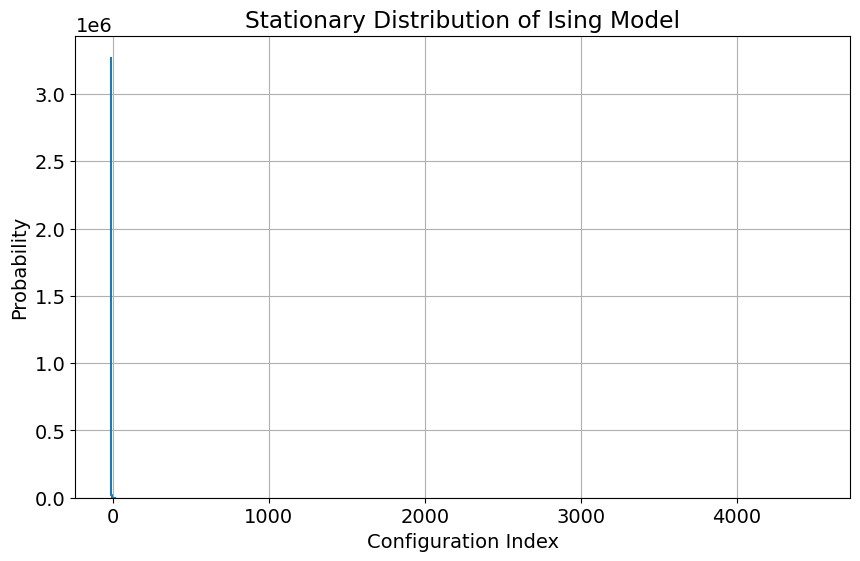

In [15]:
flattened_samples = matrices_lst
unique_configs, counts = np.unique(flattened_samples, axis=0, return_counts=True)

# Normalize counts to get probabilities
probabilities = counts / np.sum(counts)

# Sort configurations and probabilities for plotting
sorted_indices = np.argsort(probabilities)[::-1]  # Sort indices in descending order
sorted_probabilities = probabilities[sorted_indices]

# Plotting the stationary distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_probabilities)), sorted_probabilities, color='blue')
plt.step(energies, v, where='mid', linestyle='-', drawstyle='steps')
plt.xlabel('Configuration Index')
plt.ylabel('Probability')
plt.title('Stationary Distribution of Ising Model')
plt.grid(True)
plt.show()

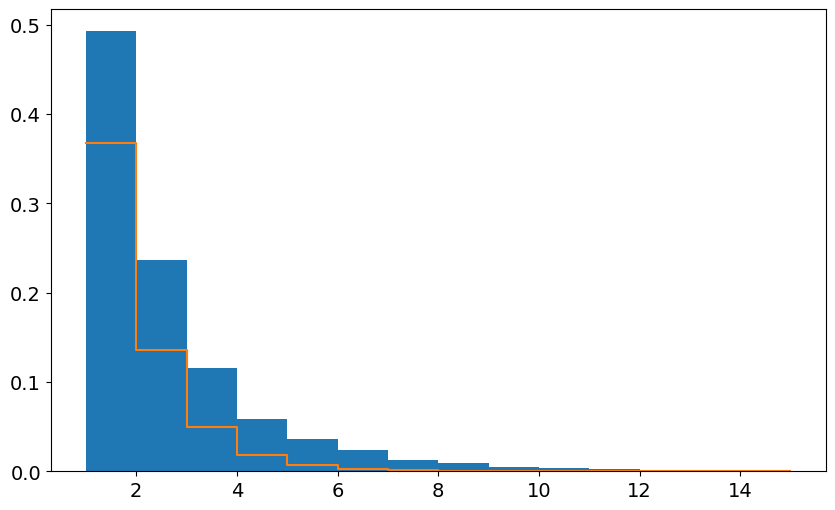

In [16]:
vals = ising_model._get_histogram_data(matrices_lst)
energies = np.linspace(1, 15, 15)

v = ising_model.gibbs_distribution(energies)
plt.figure(figsize=(10, 6))
plt.hist(sorted(counts), bins=np.linspace(1, 15, 15), density=True)
plt.step(energies, v, where='post', linestyle='-', drawstyle='steps')
plt.show()

In [17]:
'''
TEMPERATURES = [0.8, 0.95, 1.05, 1.2]

for temp in TEMPERATURES:
    if os.path.isdir(f"./data/hist_{temp}"):
        shutil.rmtree(f"./data/hist_{temp}")
        os.mkdir(f"./data/hist_{temp}")
    else:
        os.mkdir(f"./data/hist_{temp}")
    if os.path.isdir(f"./data/with_temp_{temp}"):
        shutil.rmtree(f"./data/with_temp_{temp}")
        os.mkdir(f"./data/with_temp_{temp}")
    else:
        os.mkdir(f"./data/with_temp_{temp}")
    
    ising_model = GlauberDynamicsWithTemperatureField(
        num_iterations=NUM_ITERATIONS,
        frame_length=FRAME_SIZE,
        beta=temp,
        plot_name="with_temp_field",
        folder = f"with_temp_{temp}"
        
    )
    matrices_lst = ising_model.simulate(plotting_cond=PLOTTING_CONDITION, spins=spins)
'''

'\nTEMPERATURES = [0.8, 0.95, 1.05, 1.2]\n\nfor temp in TEMPERATURES:\n    if os.path.isdir(f"./data/hist_{temp}"):\n        shutil.rmtree(f"./data/hist_{temp}")\n        os.mkdir(f"./data/hist_{temp}")\n    else:\n        os.mkdir(f"./data/hist_{temp}")\n    if os.path.isdir(f"./data/with_temp_{temp}"):\n        shutil.rmtree(f"./data/with_temp_{temp}")\n        os.mkdir(f"./data/with_temp_{temp}")\n    else:\n        os.mkdir(f"./data/with_temp_{temp}")\n    \n    ising_model = GlauberDynamicsWithTemperatureField(\n        num_iterations=NUM_ITERATIONS,\n        frame_length=FRAME_SIZE,\n        beta=temp,\n        plot_name="with_temp_field",\n        folder = f"with_temp_{temp}"\n        \n    )\n    matrices_lst = ising_model.simulate(plotting_cond=PLOTTING_CONDITION, spins=spins)\n'

In [18]:
m

NameError: name 'm' is not defined

In [ ]:
mm = [tuple(i.flatten()) for i in m]

NameError: name 'm' is not defined

In [ ]:
mm = [tuple(i.flatten()) for i in m]
test = pd.DataFrame({"a": mm})
counts = test.groupby("a")["a"].count()
#counts = [i for i in counts]
print(counts)

a
(-1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1)    1001
Name: a, dtype: int64
